# ==========================================
# 1. Imports & Configuration
# ==========================================

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [11]:
# Set plot style
sns.set_style("whitegrid")
# Display all columns when printing dataframe
pd.set_option('display.max_columns', None) # הצגת כל העמודות בהדפסה

# ==========================================
# 2. Define Column Names (NSL-KDD specific)
# ==========================================


In [12]:
# The original CSV files come without a header row.
# This list is based on the official KDD documentation.
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# ==========================================
# 3. Load Data
# ==========================================


In [13]:
train_path = '../data/raw/KDDTrain+.txt'
test_path = '../data/raw/KDDTest+.txt'

print("Loading data...")
try:
    train_df = pd.read_csv(train_path, names=columns)
    test_df = pd.read_csv(test_path, names=columns)
    print("Data loaded successfully!")
    print(f"Train set shape: {train_df.shape}")
    print(f"Test set shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check that the files exist in the 'data/raw' directory.")

Loading data...
Data loaded successfully!
Train set shape: (125973, 43)
Test set shape: (22544, 43)


# ==========================================
# 4. Data Cleaning
# ==========================================

# --- Check for Missing Values (Nulls) ---


In [14]:
print("\n[1] Checking for Missing Values (Nulls)...")
train_nulls = train_df.isnull().sum().sum()
test_nulls = test_df.isnull().sum().sum()
print(f"Nulls in Train: {train_nulls}")
print(f"Nulls in Test: {test_nulls}")



[1] Checking for Missing Values (Nulls)...
Nulls in Train: 0
Nulls in Test: 0


# --- Check and Handle Duplicates ---


In [15]:
print("\n[2] Checking for Duplicates...")
dups_train = train_df.duplicated().sum()
print(f"Duplicates in Train (before cleaning): {dups_train}")

if dups_train > 0:
    train_df.drop_duplicates(inplace=True)
    print(f"Duplicates removed. New Train shape: {train_df.shape}")
else:
    print("No duplicates found in Train set.")

# Note: It is often standard to leave the Test set untouched, 
# but for a clean project, we remove duplicates here as well.
dups_test = test_df.duplicated().sum()
if dups_test > 0:
    test_df.drop_duplicates(inplace=True)
    print(f"Duplicates removed from Test set: {dups_test}")


[2] Checking for Duplicates...
Duplicates in Train (before cleaning): 0
No duplicates found in Train set.


# --- Drop 'difficulty' Column ---

In [16]:
# The difficulty attribute was removed, 
# as it represents meta-information about sample complexity and is not intended for model training.

if 'difficulty' in train_df.columns:
    train_df.drop('difficulty', axis=1, inplace=True)
    test_df.drop('difficulty', axis=1, inplace=True)
    print("\n[3] Dropped 'difficulty' column.")


[3] Dropped 'difficulty' column.


# ==========================================
# 5. Exploratory Data Analysis (EDA)
# ==========================================


# 5.1 -- Class Distribution (Normal vs Attack) 



[4] Visualizing Class Distribution...


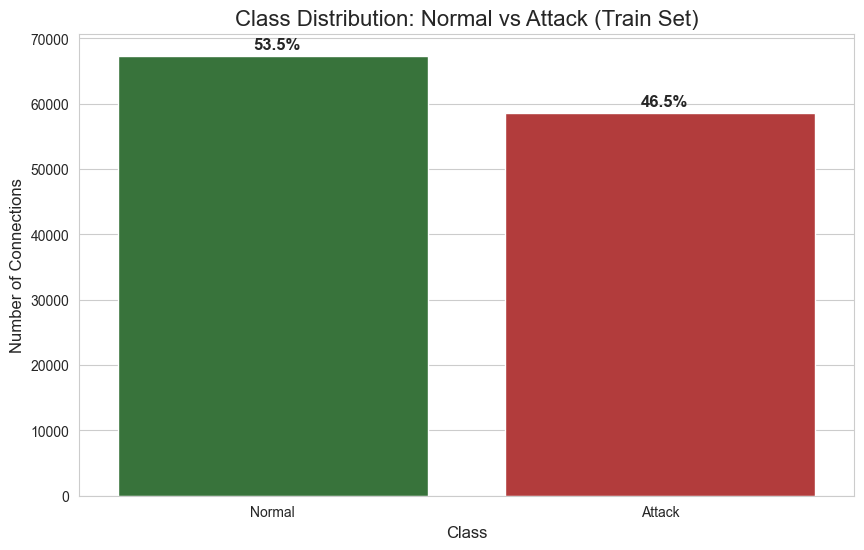

binary_label
Normal    67343
Attack    58630
Name: count, dtype: int64


In [17]:
print("\n[4] Visualizing Class Distribution...")

# Create a temporary helper column for visualization
train_df['binary_label'] = train_df['label'].apply(lambda x: 'Normal' if x == 'normal' else 'Attack')

plt.figure(figsize=(10, 6))
palette = {'Normal': '#2E7D32', 'Attack': '#C62828'}
ax = sns.countplot(
    x='binary_label',
    hue='binary_label',
    data=train_df,
    palette=palette,
    legend=False
)
plt.title('Class Distribution: Normal vs Attack (Train Set)', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Connections', fontsize=12)

# Add percentage labels above bars
total = len(train_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + 1000
    ax.annotate(percentage, (x, y), size=12, weight='bold')

plt.savefig('../results/figures/class_distribution.png', bbox_inches='tight')

plt.show()

# Print exact counts
print(train_df['binary_label'].value_counts())

# Drop the helper column to keep the dataframe clean
train_df.drop('binary_label', axis=1, inplace=True)


# 5.2 -- Correlation Analysis


[User Integration] Analyzing Correlations...

--- Top 10 Features deeply correlated with 'Attack' ---
target                      1.000000
same_srv_rate               0.751913
dst_host_srv_count          0.722535
dst_host_same_srv_rate      0.693803
logged_in                   0.690171
dst_host_srv_serror_rate    0.654985
dst_host_serror_rate        0.651842
serror_rate                 0.650652
srv_serror_rate             0.648289
count                       0.576444
dst_host_count              0.375052
Name: target, dtype: float64


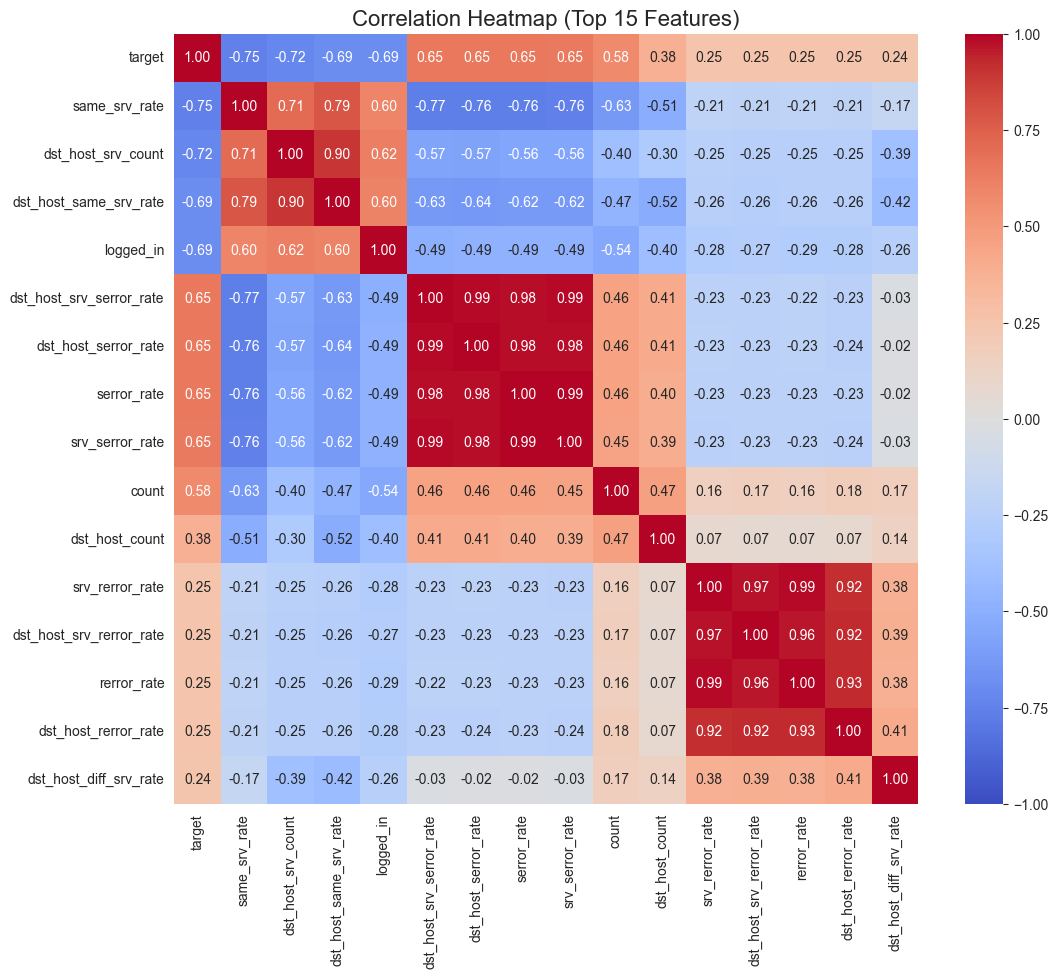


Insight from Tamir's analysis:
Features like 'dst_host_srv_serror_rate', 'dst_host_serror_rate', and 'flag' (indirectly) are strong indicators of attacks.


In [18]:
print("\n[User Integration] Analyzing Correlations...")

# יצירת עותק זמני כדי לא לפגוע בדאטה המקורי
df_corr = train_df.copy()

# המרת התווית (Label) למספר כדי שנוכל לחשב קורלציה
# 0 = Normal, 1 = Attack
df_corr['target'] = df_corr['label'].apply(lambda x: 0 if x == 'normal' else 1)

# בחירת העמודות הנומריות בלבד (קורלציה עובדת רק על מספרים)
# אנחנו משמיטים את העמודות הקטגוריאליות כרגע לצורך הויזואליזציה
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns
correlation_matrix = df_corr[numeric_cols].corr()

# א. הצגת הפיצ'רים המשפיעים ביותר על 'target'
print("\n--- Top 10 Features deeply correlated with 'Attack' ---")
# אנו לוקחים את הערך המוחלט (abs) כי קורלציה שלילית חזקה היא גם חשובה
top_corr_features = correlation_matrix['target'].abs().sort_values(ascending=False)
print(top_corr_features.head(11)) # מציגים 11 כי הראשון הוא ה-target עצמו

# ב. ציור מטריצת הקורלציה (Heatmap)
plt.figure(figsize=(12, 10))
# נציג רק את ה-15 הפיצ'רים החזקים ביותר כדי שהגרף יהיה קריא
top_15_cols = top_corr_features.head(16).index 
sns.heatmap(df_corr[top_15_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Top 15 Features)', fontsize=16)
plt.show()

print("\nInsight from Tamir's analysis:")
print("Features like 'dst_host_srv_serror_rate', 'dst_host_serror_rate', and 'flag' (indirectly) are strong indicators of attacks.")

# ==========================================
# 6. Save Processed Data
# ==========================================


In [19]:
# Save the cleaned data to the 'processed' directory for the next steps

output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

print("\n[5] Saving cleaned data to '../data/processed'...")
train_df.to_csv(f'{output_dir}/train_cleaned.csv', index=False)
test_df.to_csv(f'{output_dir}/test_cleaned.csv', index=False)
print("Done! Files saved as 'train_cleaned.csv' and 'test_cleaned.csv'.")


[5] Saving cleaned data to '../data/processed'...
Done! Files saved as 'train_cleaned.csv' and 'test_cleaned.csv'.
